## 2

install python and jupyter vscode extension

In [1]:
import numpy as np
import graph_tool.all as gt
from collections import Counter
import matplotlib.pyplot as plt
import json
import pandas as pd
import csv
import random


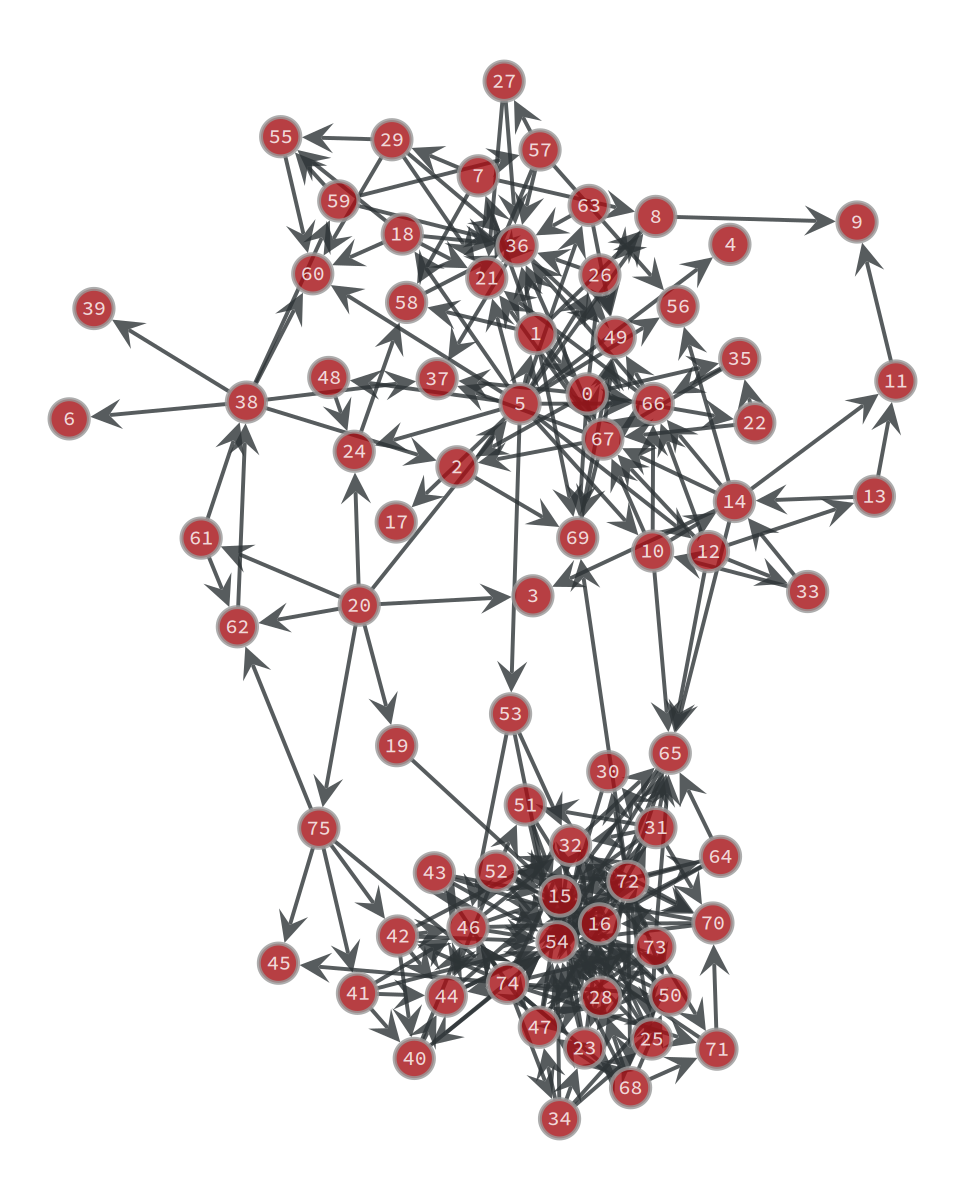

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f6c411b3aa0, at 0x7f6c411d4980>

In [80]:
import json
import graph_tool.all as gt
import matplotlib.pyplot as plt


g = gt.load_graph("/notebooks/dependency_graph.dot")

gt.graph_draw(g, vertex_text=g.vertex_index, vertex_font_size=10,  bg_color="white", 
    arrow_size=0.5)


2 packages that needed to be compatible 

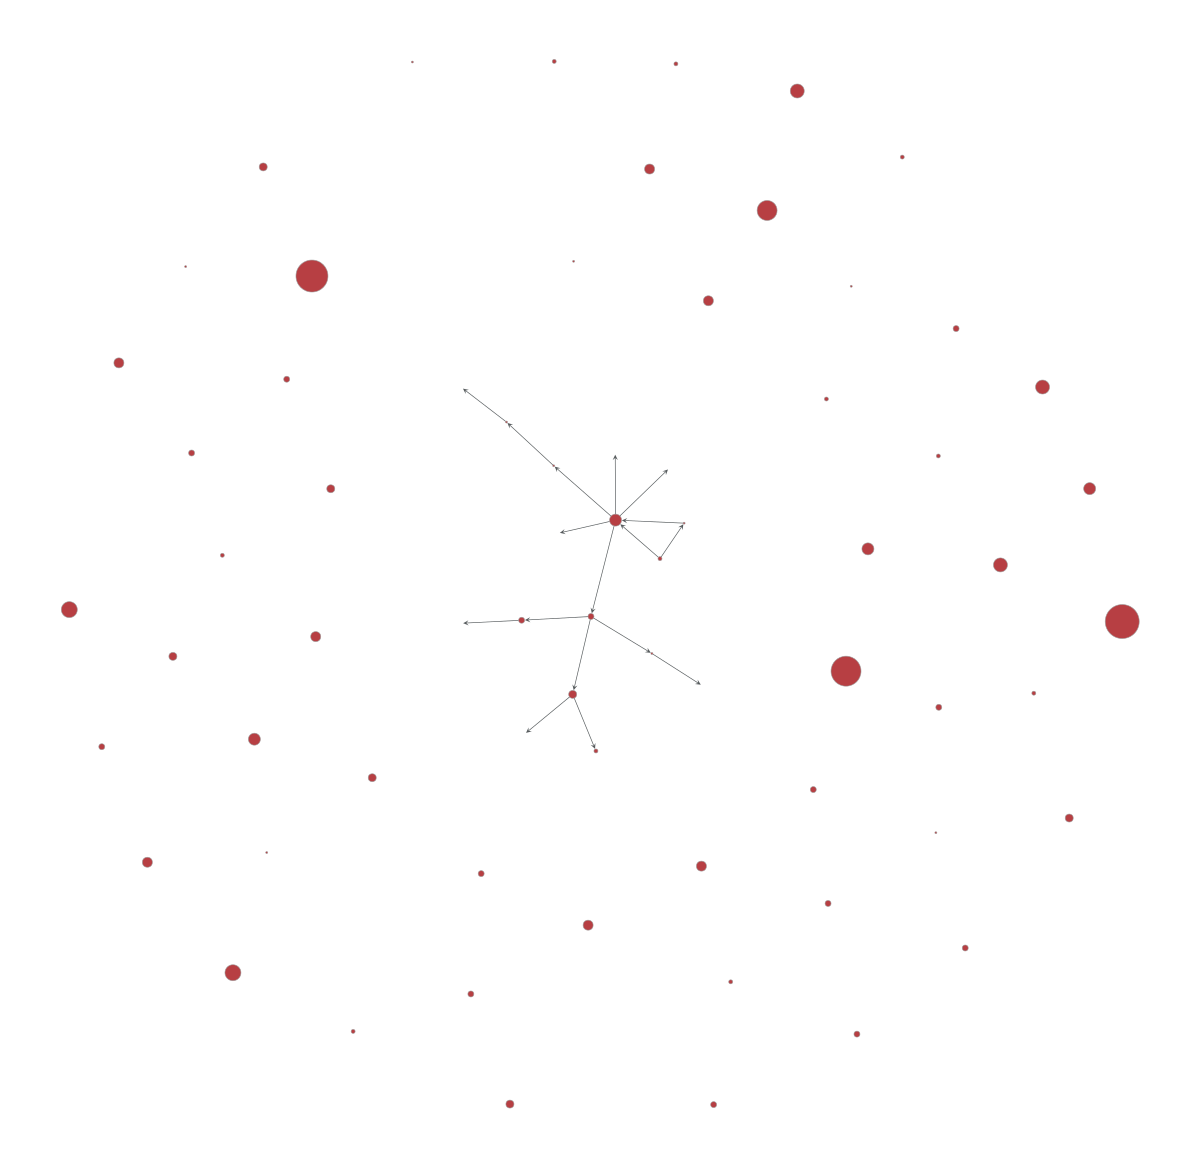

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f6c411bde20, at 0x7f6c411c8650>

In [114]:
import graph_tool.all as gt
import matplotlib.pyplot as plt

# Load the graph from DOT format
g = gt.load_graph("/notebooks/dependency_graph.graphml")

# Define target nodes
target_nodes = {"System.ServiceModel.Http/4.10.3", "System.ServiceModel.Primitives/4.10.3"}
package_name = g.vp["_graphml_vertex_id"]
target_vertices = [v for v in g.vertices() if package_name[v] in target_nodes]


# Create a vertex filter for descendants of the target nodes
descendant_filter = g.new_edge_property("bool")
for v in target_vertices:
    for descendant in gt.dfs_iterator(g, source=v):
        descendant_filter[descendant] = True

u = gt.GraphView(g, efilt= descendant_filter )
deg = g.degree_property_map("out")
gt.graph_draw(u, vertex_size=deg, bg_color="white")


Most dependents

In [78]:
import graph_tool.all as gt

# Initialize a dictionary to store path counts for each vertex
path_counts = {v: 0 for v in g.vertices()}

# Count paths to each vertex
for t in g.vertices():
    count = 0
    for s in g.vertices():
        if s != t:
            count += sum(1 for _ in gt.all_paths(g, s, t, edges=True))
    path_counts[t] = count

# Sort vertices by path count and select the top 3
top_nodes = sorted(path_counts, key=path_counts.get, reverse=True)[:3]

# Initialize edge properties for width and color
edge_width = g.new_edge_property("float", val=1)  # Default light width
edge_color = g.new_edge_property("vector<double>", val=[0.8, 0.8, 0.8, 0.5])  # Light color


Most dependencies (descendants)

In [88]:
import matplotlib.cm as cm

from graph_tool.topology import label_components

# Check if the graph is connected
comp, hist = label_components(g)
if len(hist) > 1:
    print("Graph has multiple components:", len(hist))
else:
    print("Graph is connected")

# Extract the largest component
largest_comp = gt.GraphView(g, vfilt=comp.a == comp.a.argmax())
eig_max, eig = gt.eigenvector(largest_comp)

eig_max, eig

for v in largest_comp.vertices():
    print(eig[v])

# eig_max, eig = gt.eigenvector(g)
# for v in list(g.vertices())[:3]:
#     print("eigenvalue ", eig[v])
# gt.graph_draw(g, 
#               vertex_fill_color=eig,
#               vertex_size=gt.prop_to_size(eig, mi=5, ma=15),
#               vcmap=cm.gist_heat,
#               vorder=eig,
#               bg_color="white")

#what sums up all predecessor dependant

Graph has multiple components: 76
1.0


### Katz centrality

https://en.wikipedia.org/wiki/Katz_centrality

influence is dependants of package 


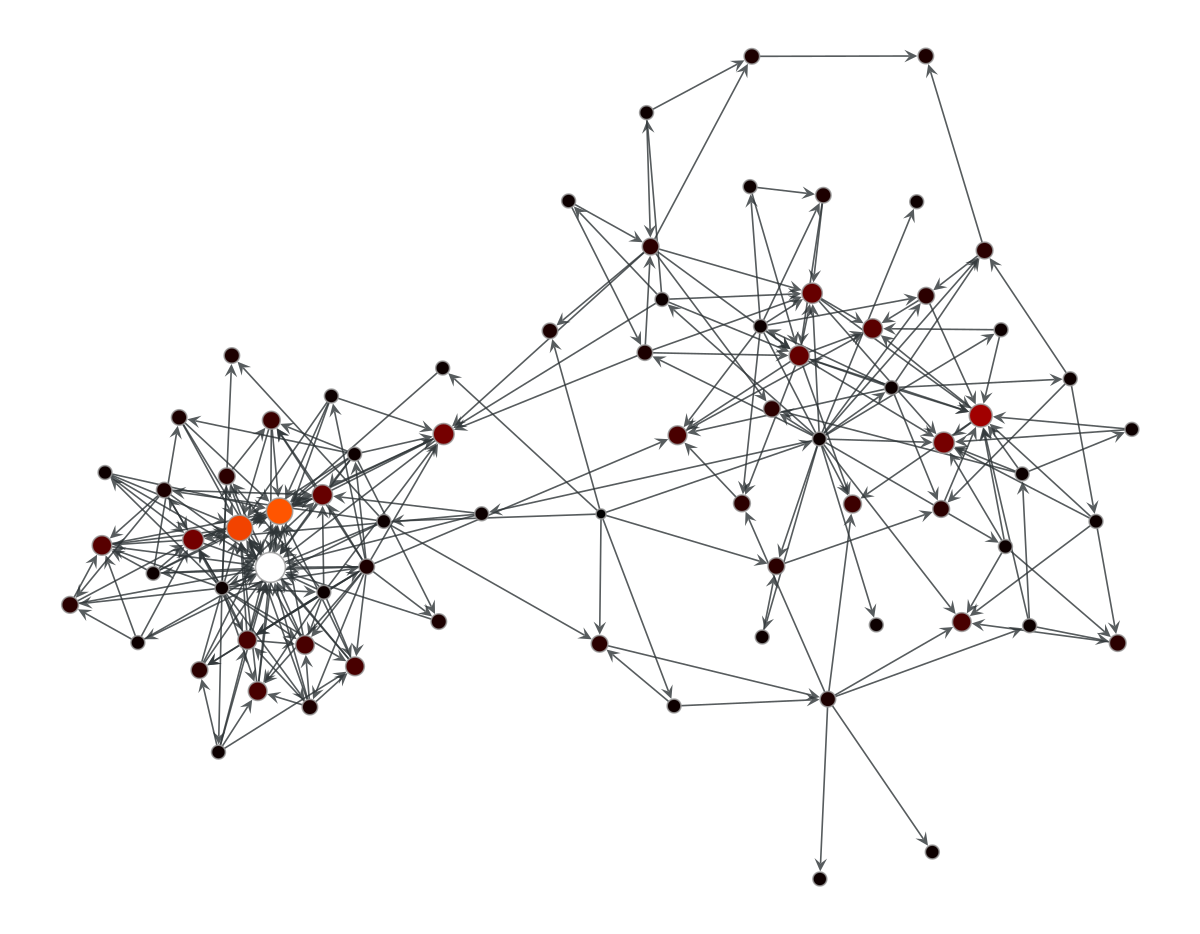

In [117]:
import matplotlib.cm as cm
def draw_katz(g):
    x = gt.katz(g)
    gt.graph_draw(g, 
                vertex_fill_color=x,
                vertex_size=gt.prop_to_size(x, mi=5, ma=15),
                vcmap=cm.gist_heat,
                vorder=x,
                bg_color="white")
draw_katz(g)

Acyclic paths to nodes of centrality

In [139]:
#helpers

package_name = g.vp["_graphml_vertex_id"]
import graph_tool.all as gt

#gets vertex, katz centrality, package name
def get_katz_tuples(g):
    katz_centrality = gt.katz(g)
    katz_tuples = [(int(v), katz_centrality[v]) for v in g.vertices()]
    katz_tuples = sorted(katz_tuples, key=lambda item: item[1], reverse=True)
    katz_tuples = [(v, x, package_name[v]) for v, x in katz_tuples]
    return katz_tuples


#gets all paths to chosen vertices in katz tuples
def get_katz_paths(katz_tuples, g):
    ls_paths = list()
   

    for t,x,name in katz_tuples:
        for s in g.vertices():
            # if s != t:
                paths = list(gt.all_paths(g, s, t, edges=True))
                for path in paths:
                    ls_paths.append(path)
                    # print([(int(e.source()), int(e.target())) for e in path])

    return ls_paths

def get_influenced(katz_paths):
    from itertools import chain
    edges = list(chain.from_iterable(katz_paths))
    vs = set()
    for e in edges:
        vs.add(e.source())
        vs.add(e.target())
    return edges, vs         



In [141]:
katz_tuples = get_katz_tuples(g)
for kt in katz_tuples[:5]:
    print(kt)
katz_paths = get_katz_paths(katz_tuples[:1], g)
edges, vs = get_influenced(katz_paths)
u = gt.GraphView(g, efilt=lambda e: e in edges )
draw_katz(u)





(49, 0.14050175899881776, 'System.Runtime/4.3.0')
(41, 0.1306263799020546, 'Microsoft.NETCore.Platforms/1.1.0')
(42, 0.12950746010986716, 'Microsoft.NETCore.Targets/1.1.0')
(20, 0.12327466100588648, 'System.Memory/4.5.5')
(27, 0.11998585043772056, 'System.Buffers/4.5.1')
dependents on [(49, 0.14050175899881776, 'System.Runtime/4.3.0')]
0 OpenCDSNETLib/1.0.0
2 Microsoft.Data.SqlClient/5.2.2
7 protobuf-net/2.4.6
23 Microsoft.IdentityModel.JsonWebTokens/6.35.0
24 Microsoft.IdentityModel.Protocols.OpenIdConnect/6.35.0
29 System.Runtime.Loader/4.3.0
36 Microsoft.IdentityModel.Tokens/6.35.0
37 System.Text.Encoding/4.3.0
39 Microsoft.IdentityModel.Protocols/6.35.0
40 System.IdentityModel.Tokens.Jwt/6.35.0
44 System.Reflection.Emit/4.3.0
45 System.Reflection.Emit.Lightweight/4.3.0
47 System.Xml.XmlSerializer/4.3.0
48 System.Collections/4.3.0
49 System.Runtime/4.3.0
50 System.Diagnostics.Debug/4.3.0
53 System.Globalization/4.3.0
54 System.IO/4.3.0
55 System.Threading.Tasks/4.3.0
56 System.IO.Fi

Edges and vertices to package of highest Katz centrality

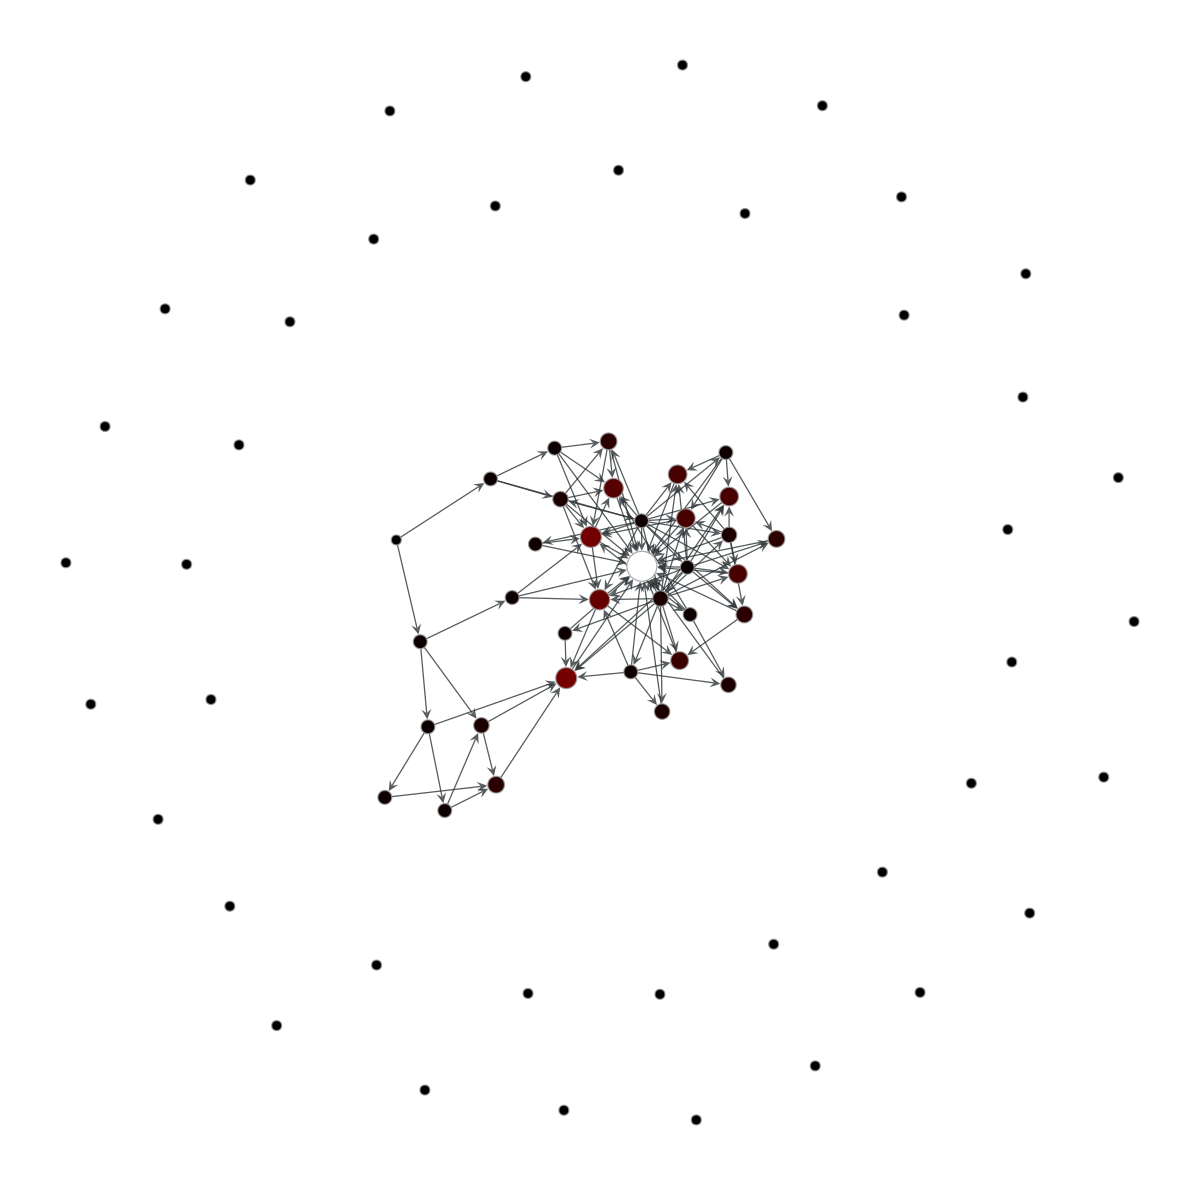

dependents on [(49, 0.14050175899881776, 'System.Runtime/4.3.0')]
0 OpenCDSNETLib/1.0.0
2 Microsoft.Data.SqlClient/5.2.2
7 protobuf-net/2.4.6
23 Microsoft.IdentityModel.JsonWebTokens/6.35.0
24 Microsoft.IdentityModel.Protocols.OpenIdConnect/6.35.0
29 System.Runtime.Loader/4.3.0
36 Microsoft.IdentityModel.Tokens/6.35.0
37 System.Text.Encoding/4.3.0
39 Microsoft.IdentityModel.Protocols/6.35.0
40 System.IdentityModel.Tokens.Jwt/6.35.0
44 System.Reflection.Emit/4.3.0
45 System.Reflection.Emit.Lightweight/4.3.0
47 System.Xml.XmlSerializer/4.3.0
48 System.Collections/4.3.0
49 System.Runtime/4.3.0
50 System.Diagnostics.Debug/4.3.0
53 System.Globalization/4.3.0
54 System.IO/4.3.0
55 System.Threading.Tasks/4.3.0
56 System.IO.FileSystem/4.3.0
57 System.IO.FileSystem.Primitives/4.3.0
58 System.Runtime.Handles/4.3.0
59 System.Linq/4.3.0
60 System.Resources.ResourceManager/4.3.0
61 System.Runtime.Extensions/4.3.0
65 System.Reflection/4.3.0
66 System.Reflection.Primitives/4.3.0
67 System.Reflection.

In [143]:
edges, vs = get_influenced(katz_paths)
u = gt.GraphView(g, efilt=lambda e: e in edges )
draw_katz(u)
print(f"dependents on {katz_tuples[:1]}")
for v in vs:
     print(v, package_name[v])

for p in katz_paths:
     print([(int(e.source()), int(e.target())) for e in p])

influence is most dependencies

47 0.13054870359328732 System.Xml.XmlSerializer/4.3.0
2 0.12892844560904762 Microsoft.Data.SqlClient/5.2.2
74 0.12806350265940172 System.Xml.ReaderWriter/4.3.0
75 0.12239042471903039 System.Xml.XmlDocument/4.3.0
8 0.11987990729967767 Azure.Core/1.38.0

Paths leading to  (47, 'System.Xml.XmlSerializer/4.3.0'):


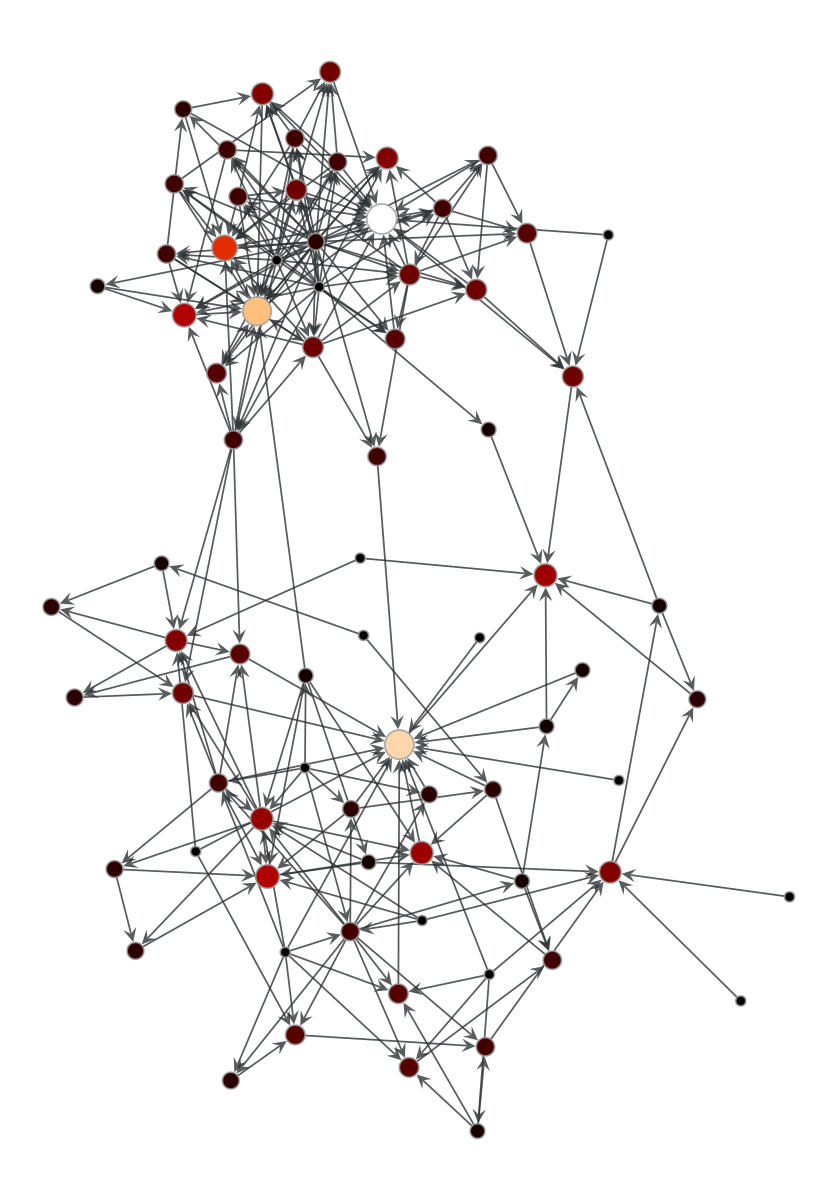

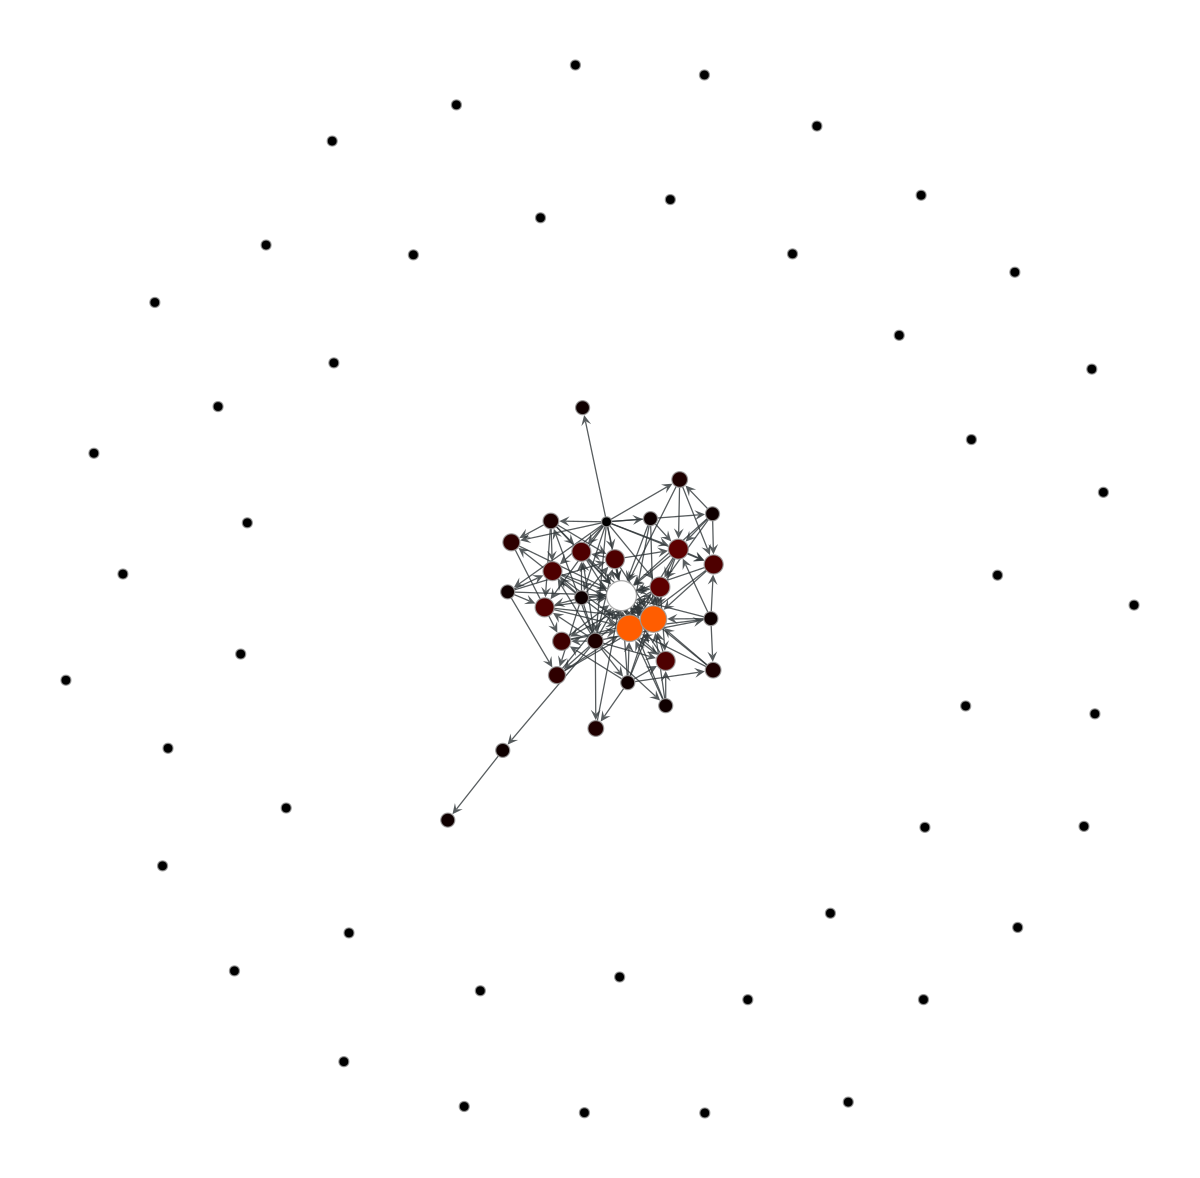

In [134]:


g_reversed = gt.Graph(g, directed=True)
g_reversed.set_reversed(True)  # This reverses the direction of all edges
katz_tuples = get_katz_tuples(g_reversed)
katz_paths = get_katz_paths(katz_tuples[:1], g_reversed)
edges, vs = get_influenced(katz_paths)
u = gt.GraphView(g, efilt=lambda e: e in edges )
draw_katz(g_reversed)
draw_katz(u)
